In [2]:
import torch
import torchvision.transforms as T
from torch_snippets import *


In [2]:
torch.cuda.is_available()

True

In [20]:
!pip3 install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 27.3 MB/s eta 0:00:0000:0100:01


In [22]:
def normals(m,mean,std):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        m.weight.data.normal_(mean,std)
        m.bias.data.zero_()

In [3]:
!ls

ShoeV2_photo  ShoeV2_photo.zip	Starter.ipynb


In [3]:
!wget https://bit.ly/3kiuN93

--2022-12-10 18:49:27--  https://bit.ly/3kiuN93
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.qmul.ac.uk/~qian/Qian's Materials/ShoeV2.zip [following]
--2022-12-10 18:49:27--  https://www.eecs.qmul.ac.uk/~qian/Qian's%20Materials/ShoeV2.zip
Resolving www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)... 138.37.95.147
Connecting to www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)|138.37.95.147|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-10 18:49:29 ERROR 404: Not Found.



In [3]:
!ls ./ShoeV2_photo

1000.png  1499.png  1997.png  2495.png	2993.png  3490.png  3984.png  505.png
1001.png  149.png   1998.png  2496.png	2994.png  3491.png  3985.png  506.png
1002.png  1500.png  1999.png  2497.png	2995.png  3492.png  3986.png  507.png
1003.png  1501.png  199.png   2498.png	2996.png  3493.png  3987.png  508.png
1004.png  1502.png  2000.png  2499.png	2997.png  3494.png  3988.png  509.png
1005.png  1503.png  2001.png  249.png	2998.png  3495.png  3989.png  50.png
1006.png  1504.png  2002.png  2500.png	2999.png  3496.png  398.png   510.png
1007.png  1505.png  2003.png  2501.png	299.png   3497.png  3990.png  511.png
1008.png  1506.png  2004.png  2502.png	3000.png  3498.png  3991.png  512.png
1009.png  1507.png  2005.png  2503.png	3001.png  3499.png  3992.png  513.png
100.png   1508.png  2006.png  2504.png	3002.png  349.png   3993.png  514.png
1010.png  1509.png  2007.png  2505.png	3003.png  34.png    3994.png  515.png
1011.png  150.png   2008.png  2506.png	3004.png  3500.png  3995.png  516.png
1

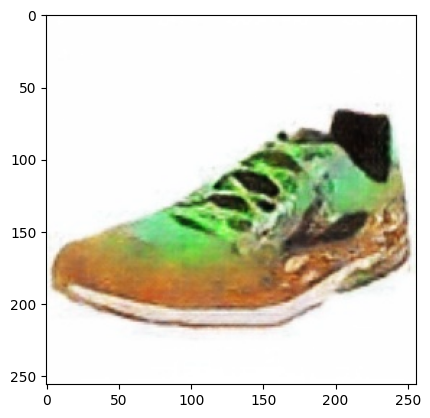

In [4]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('./ShoeV2_photo/1144.png',cv2.IMREAD_COLOR)
plt.imshow(img)

In [5]:
def edges(images):
    gray = cv2.cvtColor(images,cv2.COLOR_RGB2GRAY)
    gray = cv2.bilateralFilter(gray,5,50,50)
    ed =  cv2.Canny(gray,45,100)
    ed =  cv2.bitwise_not(ed)
    ed = cv2.cvtColor(ed,cv2.COLOR_GRAY2RGB)
    return ed

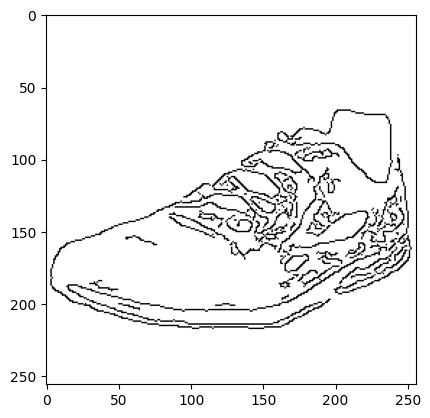

In [6]:
edg = edges(img)
plt.imshow(edg)

In [6]:
IMAGE_SIZE= 256
augments= T.Compose([
    T.ToTensor(),
    T.Resize(IMAGE_SIZE),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
class Data(Dataset):
    def __init__(self,items):
        self.items =  items
    def __len__(self):
        return len(self.items)
    def __getitem__(self,ix):
#         print(self.items[ix])
        imgp = self.items[ix]
        img = cv2.imread(os.path.join('./',imgp) ,cv2.IMREAD_COLOR)
        imgedge = edges(img)
        img = augments(img)
        imgedge = augments(imgedge)
        return imgedge,img

In [8]:
import sklearn
from sklearn.model_selection import train_test_split
train_items, val_items = train_test_split(Glob('ShoeV2_photo/*.png'),test_size=0.2, random_state=2)

In [9]:
trn_ds, val_ds = Data(train_items), Data(val_items)

In [26]:
trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True,drop_last=True,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True,drop_last=True,pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


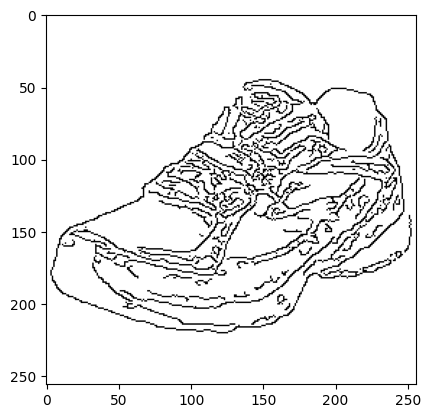

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


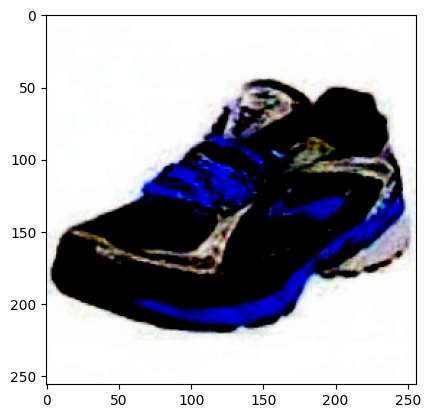

In [51]:
imged,img = next(iter(trn_dl))
plt.imshow(imged[5].permute(1, 2, 0).numpy())
plt.show()
plt.imshow(img[5].permute(1, 2, 0).numpy())
plt.show()

In [11]:
class Ck(nn.Module):
    def __init__(self,in_ch,out_ch,s=2,up=False):
        super().__init__()
        if up:
            self.layers  = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch,out_channels=out_ch,kernel_size=4,padding=1,stride=s,bias=False),
            nn.BatchNorm2d(num_features=out_ch),
            nn.ReLU(inplace=True),
        ) 
        else:
            self.layers  = nn.Sequential(
                nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=4,padding=1,stride=s),
                nn.BatchNorm2d(num_features=out_ch),
                nn.LeakyReLU(negative_slope=0.2,inplace=True),
            )
    def forward(self,inputs):
        x = self.layers(inputs)
        return x
class CDk(nn.Module):
    def __init__(self,in_ch,out_ch,s=2,up=False):
        super().__init__()
        if up:
            self.layers  = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch,out_channels=out_ch,kernel_size=4,padding=1,stride=s),
                nn.BatchNorm2d(num_features=out_ch),
                nn.Dropout(p=0.5),
                nn.ReLU(inplace=True)
            )
        else:
            self.layers  = nn.Sequential(
                nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=4,padding=1,stride=s),
                nn.BatchNorm2d(num_features=out_ch),
                nn.Dropout(p=0.5),
                nn.LeakyReLU(negative_slope=0.2,inplace=True)
            )
    def forward(self,inputs):
        x = self.layers(inputs)
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self,in_ch):
        super(Generator,self).__init__()
        self.d1 = Ck(in_ch,64)
        self.d2 = Ck(64,128)
        self.d3 = Ck(128,256)
        self.d4 = Ck(256,512)
        self.d5 = Ck(512,512)
        self.d6 = Ck(512,512)
        self.d7 = Ck(512,512)
        self.d8 = Ck(512,512)
        self.u1 = CDk(512,512,up=True)
        self.u2 = CDk(1024,512,up=True)
        self.u3 = CDk(1024,512,up=True)
        self.u4 = Ck(1024,512,up=True)
        self.u5 = Ck(1024,256,up=True)
        self.u6 = Ck(512,128,up=True)
        self.u7 = Ck(256,64,up=True)
#         self.u8 = Ck(256,128,up=True)
        self.c1 = nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=4,padding=1,stride=2)
        self.out =nn.Tanh()
    def weight_init(self, mean, std):
        for m in self._modules:
            print(m)
            normals(self._modules[m], mean, std)
    def forward(self,inputs):
        e1 = self.d1(inputs)
        e2 = self.d2(e1)
        e3 = self.d3(e2)
        e4 = self.d4(e3)
        e5 = self.d5(e4)
        e6 = self.d6(e5)
        e7 = self.d7(e6)
        e8 = self.d8(e7)
        
        f1 = self.u1(e8)
        f11 = torch.cat([f1, e7], dim=1)
        f2= self.u2(f11)
        f22 = torch.cat([f2, e6], dim=1)
        f3= self.u3(f22)
        f33 = torch.cat([f3, e5], dim=1)
        f4= self.u4(f33)
        f44 = torch.cat([f4, e4], dim=1)
        f5 = self.u5(f44)
        f55 = torch.cat([f5, e3], dim=1)
        f6= self.u6(f55)
        f66 = torch.cat([f6, e2], dim=1)
        f7= self.u7(f66)
        f77 = torch.cat([f7, e1], dim=1)
        
        o = self.c1(f77)
        o = self.out(o)
        
        return o
        
        

In [13]:
class Discriminator(nn.Module):
    def __init__(self,in_ch):
        super(Discriminator,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_ch*2,out_channels=64,kernel_size=4,padding=1,stride=2),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,padding=1,stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,padding=1,stride=2),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,padding=1,stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,padding=1,stride=1),
            nn.Sigmoid()
         )
    def weight_init(self, mean, std):
            for m in self._modules:
                normals(self._modules[m], mean, std)
    def forward(self,inputs,label):
            out = self.layers(torch.cat([inputs, label], dim=1))
            return out

In [43]:
!nvidia-smi

Sun Dec 11 11:03:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.10   Driver Version: 470.141.10   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   40C    P8    10W / 170W |  10303MiB / 12053MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B3:00.0 Off |                  N/A |
| 30%   

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
generator = Generator(3).to(device)
discriminator = Discriminator(3).to(device)

In [23]:
generator.weight_init(0.0,0.02)
discriminator.weight_init(0.0,0.02)

d1

d2

d3

d4

d5

d6

d7

d8

u1

u2

u3

u4

u5

u6

u7

c1

out

In [60]:
!pip install torch_summary

In [18]:
from torchsummary import summary

In [19]:
print(summary(generator, torch.zeros(3, 3, IMAGE_SIZE,IMAGE_SIZE).to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Ck: 1-1                                [-1, 64, 128, 128]        --
|    └─Sequential: 2-1                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 128, 128]        3,136
|    |    └─BatchNorm2d: 3-2             [-1, 64, 128, 128]        128
|    |    └─LeakyReLU: 3-3               [-1, 64, 128, 128]        --
├─Ck: 1-2                                [-1, 128, 64, 64]         --
|    └─Sequential: 2-2                   [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-4                  [-1, 128, 64, 64]         131,200
|    |    └─BatchNorm2d: 3-5             [-1, 128, 64, 64]         256
|    |    └─LeakyReLU: 3-6               [-1, 128, 64, 64]         --
├─Ck: 1-3                                [-1, 256, 32, 32]         --
|    └─Sequential: 2-3                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 32, 32]         524,544


==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Ck: 1-1                                [-1, 64, 128, 128]        --
|    └─Sequential: 2-1                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 128, 128]        3,136
|    |    └─BatchNorm2d: 3-2             [-1, 64, 128, 128]        128
|    |    └─LeakyReLU: 3-3               [-1, 64, 128, 128]        --
├─Ck: 1-2                                [-1, 128, 64, 64]         --
|    └─Sequential: 2-2                   [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-4                  [-1, 128, 64, 64]         131,200
|    |    └─BatchNorm2d: 3-5             [-1, 128, 64, 64]         256
|    |    └─LeakyReLU: 3-6               [-1, 128, 64, 64]         --
├─Ck: 1-3                                [-1, 256, 32, 32]         --
|    └─Sequential: 2-3                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 32, 32]         524,544
|    |    └─BatchNorm2d: 3-8             [-1, 256, 32, 32]         512
|    |    └─LeakyReLU: 3-9               [-1, 256, 32, 32]         --
├─Ck: 1-4                                [-1, 512, 16, 16]         --
|    └─Sequential: 2-4                   [-1, 512, 16, 16]         --
|    |    └─Conv2d: 3-10                 [-1, 512, 16, 16]         2,097,664
|    |    └─BatchNorm2d: 3-11            [-1, 512, 16, 16]         1,024
|    |    └─LeakyReLU: 3-12              [-1, 512, 16, 16]         --
├─Ck: 1-5                                [-1, 512, 8, 8]           --
|    └─Sequential: 2-5                   [-1, 512, 8, 8]           --
|    |    └─Conv2d: 3-13                 [-1, 512, 8, 8]           4,194,816
|    |    └─BatchNorm2d: 3-14            [-1, 512, 8, 8]           1,024
|    |    └─LeakyReLU: 3-15              [-1, 512, 8, 8]           --
├─Ck: 1-6                                [-1, 512, 4, 4]           --
|    └─Sequential: 2-6                   [-1, 512, 4, 4]           --
|    |    └─Conv2d: 3-16                 [-1, 512, 4, 4]           4,194,816
|    |    └─BatchNorm2d: 3-17            [-1, 512, 4, 4]           1,024
|    |    └─LeakyReLU: 3-18              [-1, 512, 4, 4]           --
├─Ck: 1-7                                [-1, 512, 2, 2]           --
|    └─Sequential: 2-7                   [-1, 512, 2, 2]           --
|    |    └─Conv2d: 3-19                 [-1, 512, 2, 2]           4,194,816
|    |    └─BatchNorm2d: 3-20            [-1, 512, 2, 2]           1,024
|    |    └─LeakyReLU: 3-21              [-1, 512, 2, 2]           --
├─Ck: 1-8                                [-1, 512, 1, 1]           --
|    └─Sequential: 2-8                   [-1, 512, 1, 1]           --
|    |    └─Conv2d: 3-22                 [-1, 512, 1, 1]           4,194,816
|    |    └─BatchNorm2d: 3-23            [-1, 512, 1, 1]           1,024
|    |    └─LeakyReLU: 3-24              [-1, 512, 1, 1]           --
├─CDk: 1-9                               [-1, 512, 2, 2]           --
|    └─Sequential: 2-9                   [-1, 512, 2, 2]           --
|    |    └─ConvTranspose2d: 3-25        [-1, 512, 2, 2]           4,194,816
|    |    └─BatchNorm2d: 3-26            [-1, 512, 2, 2]           1,024
|    |    └─Dropout: 3-27                [-1, 512, 2, 2]           --
|    |    └─ReLU: 3-28                   [-1, 512, 2, 2]           --
├─CDk: 1-10                              [-1, 512, 4, 4]           --
|    └─Sequential: 2-10                  [-1, 512, 4, 4]           --
|    |    └─ConvTranspose2d: 3-29        [-1, 512, 4, 4]           8,389,120
|    |    └─BatchNorm2d: 3-30            [-1, 512, 4, 4]           1,024
|    |    └─Dropout: 3-31                [-1, 512, 4, 4]           --
|    |    └─ReLU: 3-32                   [-1, 512, 4, 4]           --
├─CDk: 1-11      

In [20]:
print(summary(discriminator, torch.zeros(3, 3, IMAGE_SIZE,IMAGE_SIZE).to(device), torch.zeros(3, 3,IMAGE_SIZE, IMAGE_SIZE).to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 30, 30]           --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        6,208
|    └─LeakyReLU: 2-2                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-3                       [-1, 128, 64, 64]         131,200
|    └─BatchNorm2d: 2-4                  [-1, 128, 64, 64]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 64, 64]         --
|    └─Conv2d: 2-6                       [-1, 256, 32, 32]         524,544
|    └─BatchNorm2d: 2-7                  [-1, 256, 32, 32]         512
|    └─LeakyReLU: 2-8                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-9                       [-1, 512, 31, 31]         2,097,664
|    └─BatchNorm2d: 2-10                 [-1, 512, 31, 31]         1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 31, 31]         --
|    └─Conv2d: 2-12                      [-1, 1, 30, 30]    

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 1, 30, 30]           --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        6,208
|    └─LeakyReLU: 2-2                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-3                       [-1, 128, 64, 64]         131,200
|    └─BatchNorm2d: 2-4                  [-1, 128, 64, 64]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 64, 64]         --
|    └─Conv2d: 2-6                       [-1, 256, 32, 32]         524,544
|    └─BatchNorm2d: 2-7                  [-1, 256, 32, 32]         512
|    └─LeakyReLU: 2-8                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-9                       [-1, 512, 31, 31]         2,097,664
|    └─BatchNorm2d: 2-10                 [-1, 512, 31, 31]         1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 31, 31]         --
|    └─Conv2d: 2-12                      [-1, 1, 30, 30]           8,193
|    └─Sigmoid: 2-13                     [-1, 1, 30, 30]           --
==========================================================================================
Total params: 2,769,601
Trainable params: 2,769,601
Non-trainable params: 0
Total mult-adds (G): 3.20
==========================================================================================
Input size (MB): 2.25
Forward/backward pass size (MB): 27.51
Params size (MB): 10.57
Estimated Total Size (MB): 40.33
==========================================================================================

In [57]:
def discriminator_step(src_img,true_img,fake_img):
    D_optimizer.zero_grad()
    D_real = discriminator(src_img,true_img)
    D_real_loss = BCELoss(D_real,torch.ones_like(D_real))
    D_fake = discriminator(src_img,fake_img.detach())
    D_fake_loss = BCELoss(D_fake,torch.zeros_like(D_fake))
    D_train_loss = (D_real_loss+D_fake_loss)/2
    D_train_loss.backward()
    D_optimizer.step()
    return D_train_loss
def generator_step(src_img,true_img,fake_img):
    G_optimizer.zero_grad()
    D_fake = discriminator(src_img,fake_img.detach())
    G_train_loss = BCELoss(D_fake,torch.ones_like(D_fake)) + L1Loss(true_img,fake_img)
    G_train_loss.backward()
    G_optimizer.step() 
    return G_train_loss
def some_examples():
    x,y = next(iter(val_dl))
    x =x.to(DEVICE)
    y =y.to(DEVICE)
    generator.eval()
    with torch.no_grad():
        y_pred = generator(x)
        y_pred = y_pred*0.5 +0.5
#         wandb.log({'preds ':y_pred,'true':y},step=epoch)
        img_sample = torch.cat([x[0],y_pred[0],y[0]], -1)
        img_sample = img_sample.detach().cpu().permute(1,2,0).numpy()
        plt.imshow((img_sample * 255).astype(np.uint8))
        plt.show()
    generator.train()

    

In [34]:
G_optimizer = torch.optim.Adam(generator.parameters(),lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.0002, betas=(0.5, 0.999))

In [27]:
import time

In [36]:
BCELoss= nn.BCELoss()
L1Loss = nn.L1Loss()

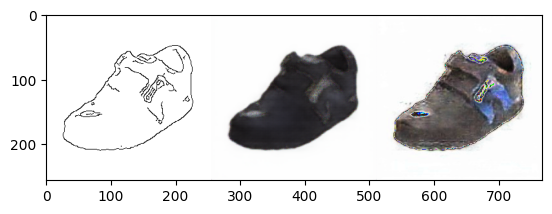

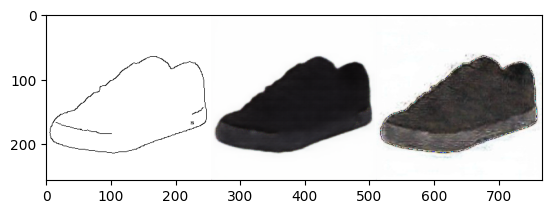

[1/200] - ptime: 78.21, loss_d: 0.003, loss_g: 5.949

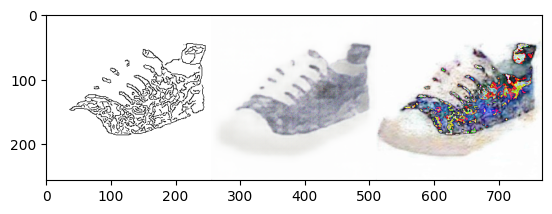

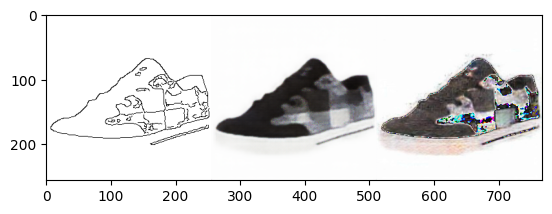

[2/200] - ptime: 78.48, loss_d: 0.002, loss_g: 6.276

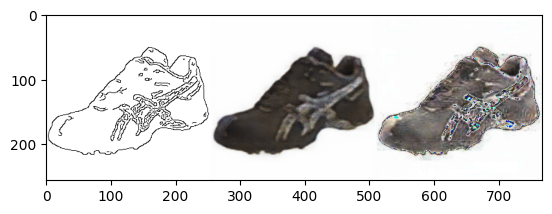

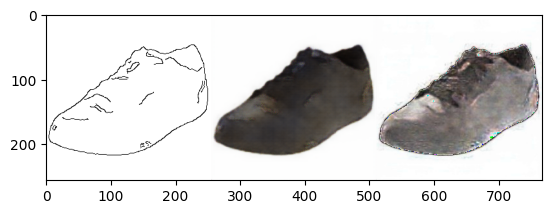

[3/200] - ptime: 78.44, loss_d: 0.466, loss_g: 2.705

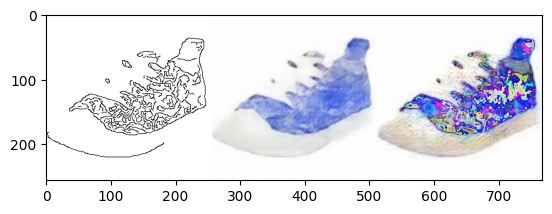

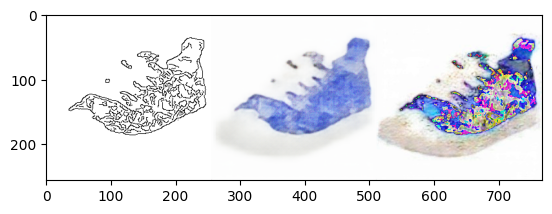

[4/200] - ptime: 78.34, loss_d: 0.372, loss_g: 1.941

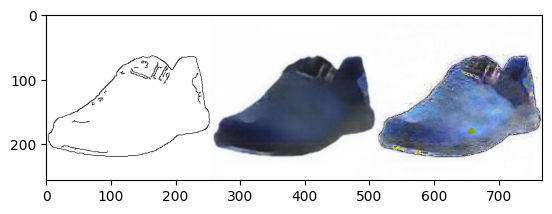

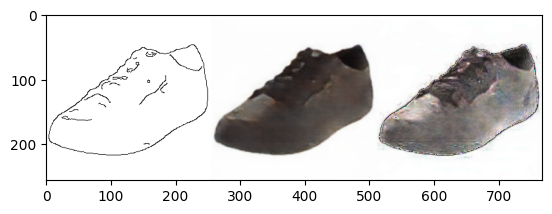

[5/200] - ptime: 78.62, loss_d: 0.248, loss_g: 2.799

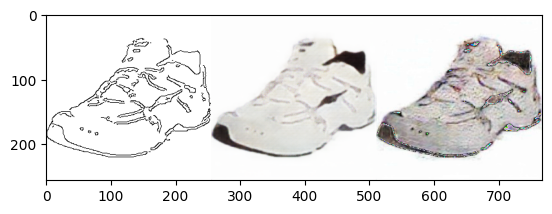

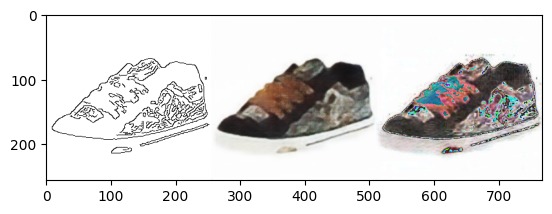

[6/200] - ptime: 78.30, loss_d: 0.204, loss_g: 3.322

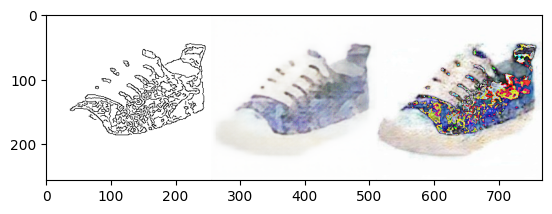

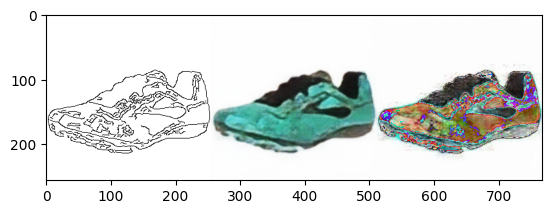

[7/200] - ptime: 78.27, loss_d: 0.351, loss_g: 2.076

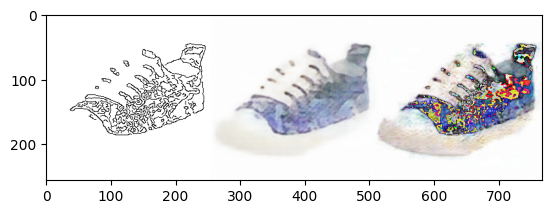

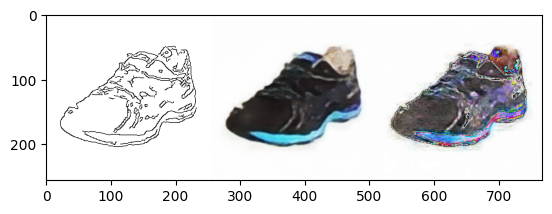

[8/200] - ptime: 78.39, loss_d: 0.478, loss_g: 1.635

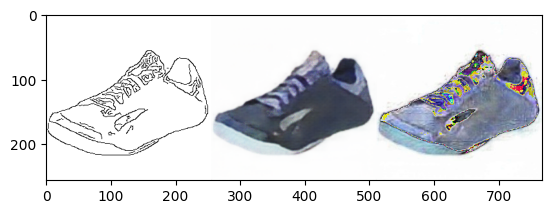

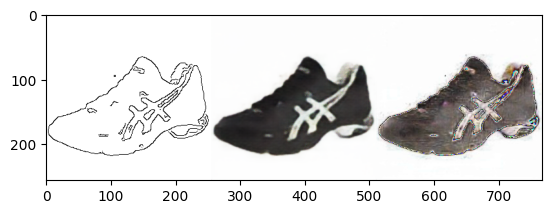

[9/200] - ptime: 78.41, loss_d: 0.548, loss_g: 1.320

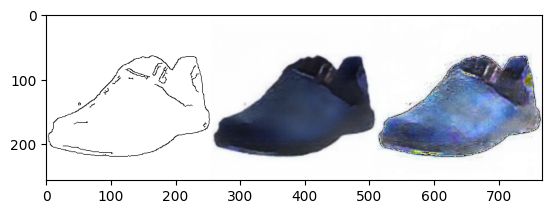

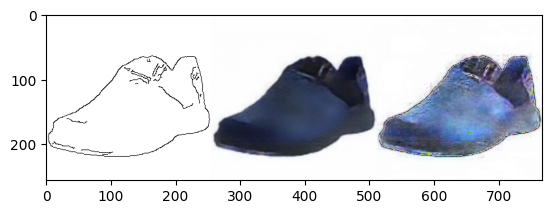

[10/200] - ptime: 78.35, loss_d: 0.523, loss_g: 1.337

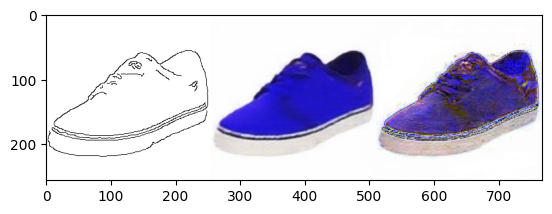

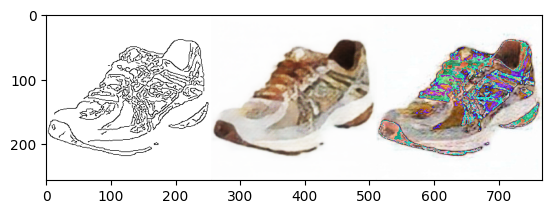

[11/200] - ptime: 78.37, loss_d: 0.574, loss_g: 1.272

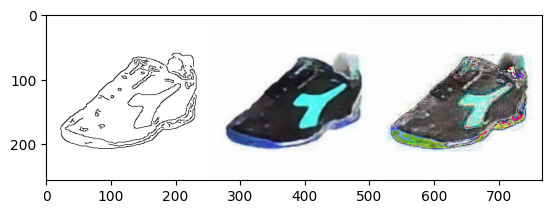

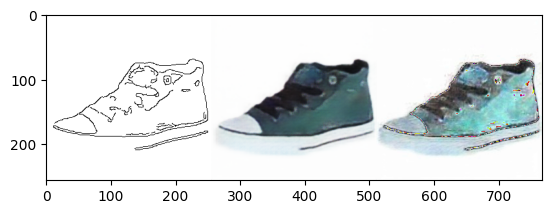

[12/200] - ptime: 78.32, loss_d: 0.557, loss_g: 1.239

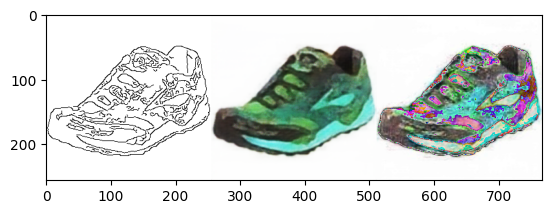

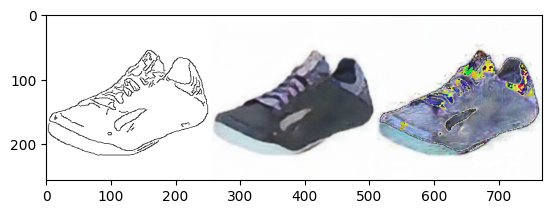

[13/200] - ptime: 78.25, loss_d: 0.601, loss_g: 1.106

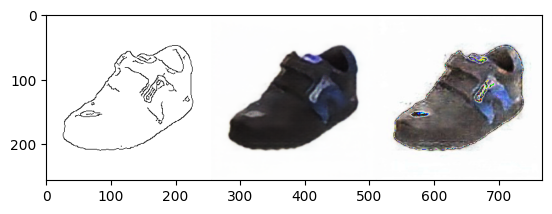

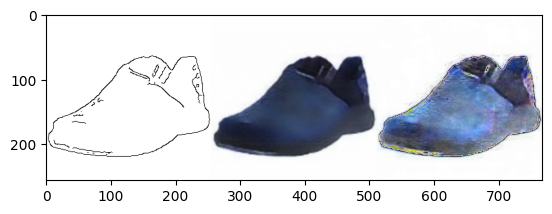

[14/200] - ptime: 78.38, loss_d: 0.550, loss_g: 1.170

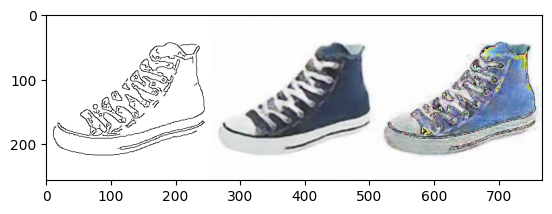

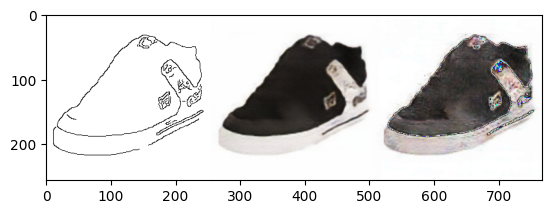

[15/200] - ptime: 78.50, loss_d: 0.638, loss_g: 0.969

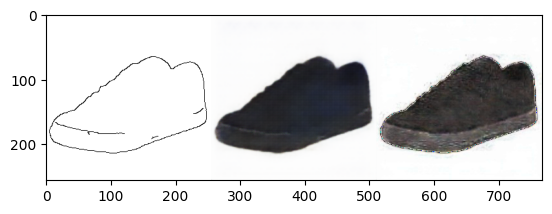

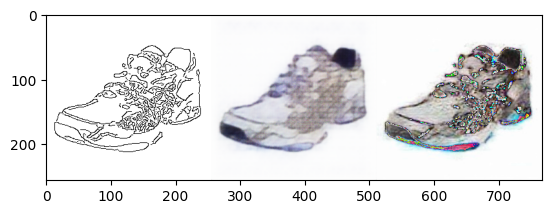

[16/200] - ptime: 78.47, loss_d: 0.377, loss_g: 2.122

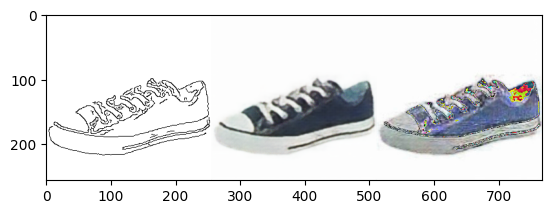

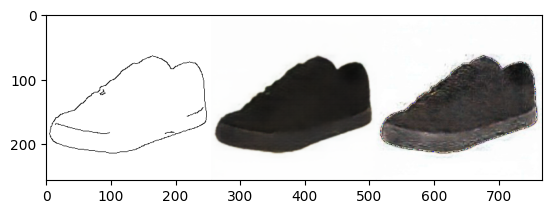

[17/200] - ptime: 78.41, loss_d: 0.455, loss_g: 1.884

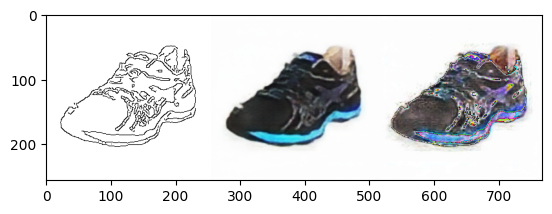

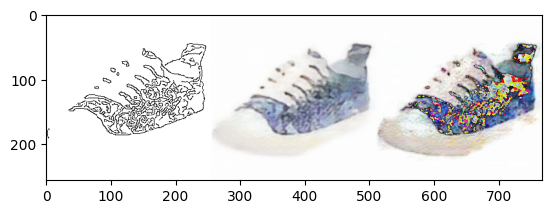

[18/200] - ptime: 78.40, loss_d: 0.570, loss_g: 1.237

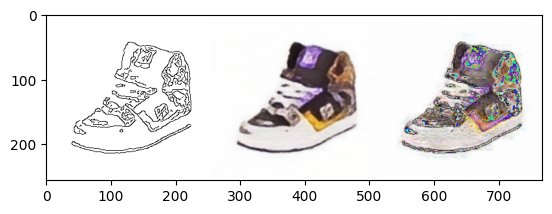

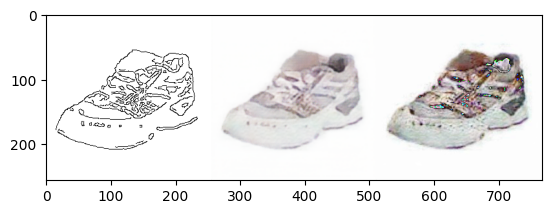

[19/200] - ptime: 78.47, loss_d: 0.553, loss_g: 1.256

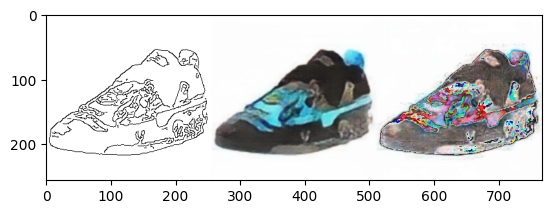

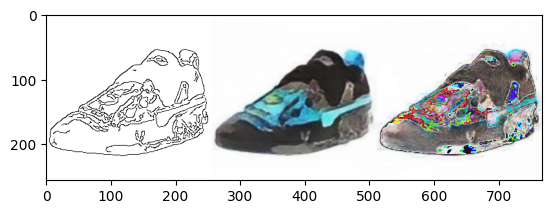

[20/200] - ptime: 78.45, loss_d: 0.545, loss_g: 1.260

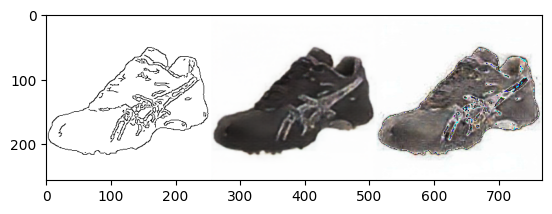

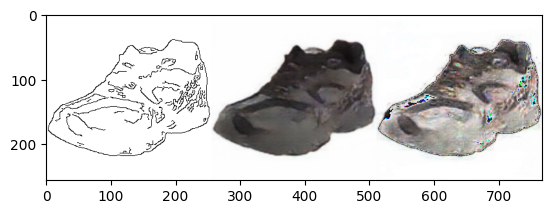

[21/200] - ptime: 78.27, loss_d: 0.529, loss_g: 1.376

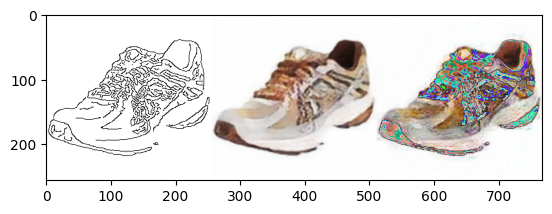

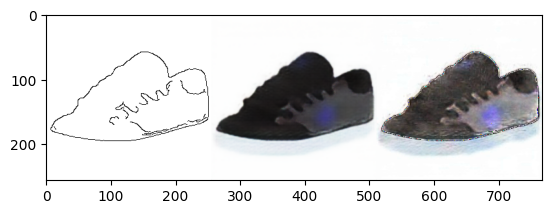

[22/200] - ptime: 78.40, loss_d: 0.528, loss_g: 1.315

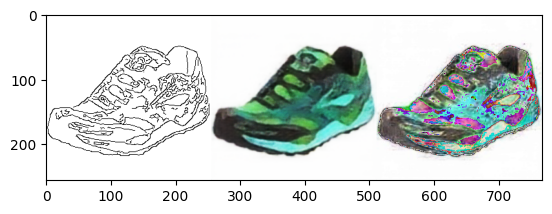

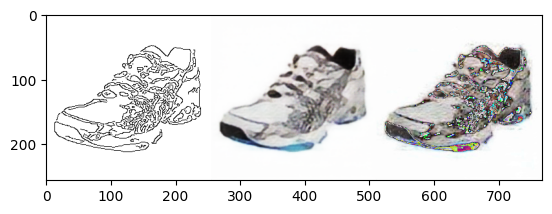

[23/200] - ptime: 78.28, loss_d: 0.501, loss_g: 1.381

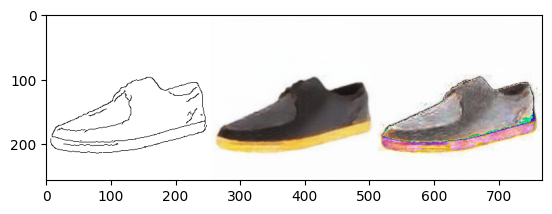

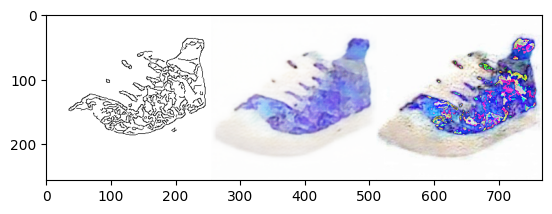

[24/200] - ptime: 78.38, loss_d: 0.507, loss_g: 1.345

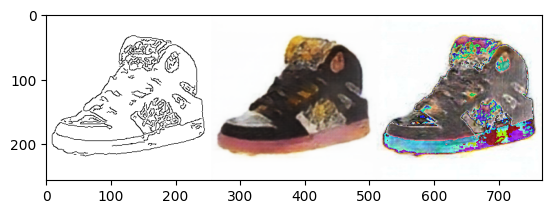

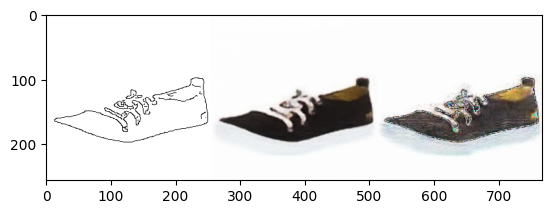

[25/200] - ptime: 78.39, loss_d: 0.415, loss_g: 1.628

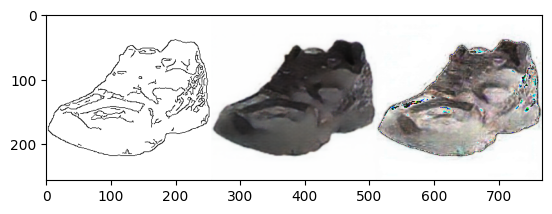

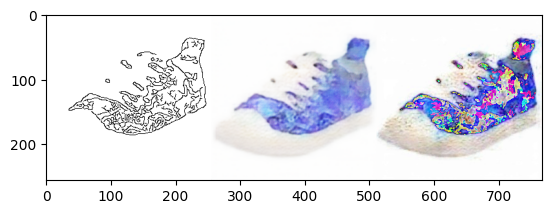

[26/200] - ptime: 78.40, loss_d: 0.278, loss_g: 2.330

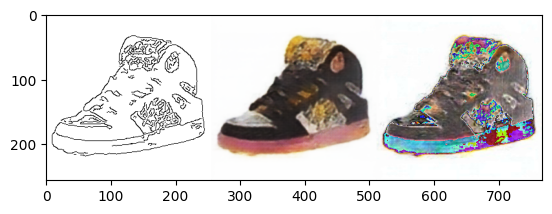

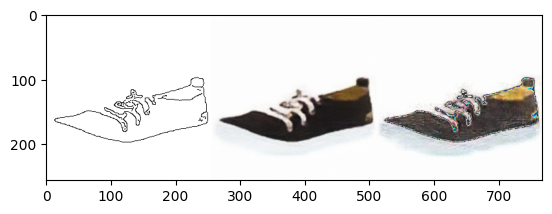

[27/200] - ptime: 78.32, loss_d: 0.320, loss_g: 2.060

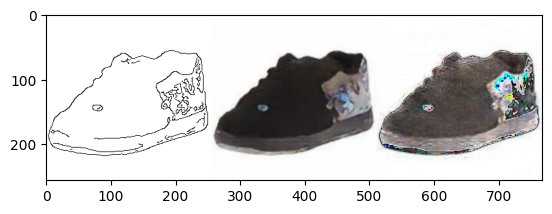

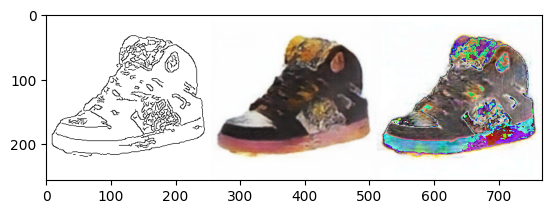

[28/200] - ptime: 78.43, loss_d: 0.077, loss_g: 3.515

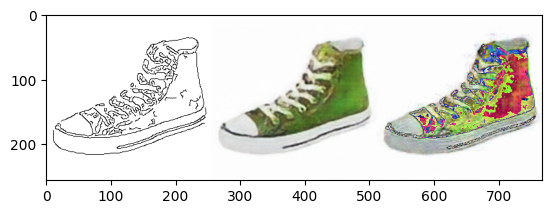

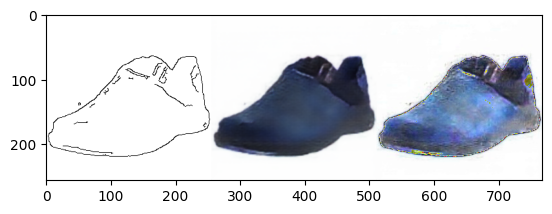

[29/200] - ptime: 78.48, loss_d: 0.020, loss_g: 4.327

KeyboardInterrupt: 

In [58]:
epochs = 100
start_time = time.time()
for epoch in range(epochs):
    N = len(trn_dl)
    D_loss=[]
    G_loss=[]
    epoch_s = time.time()
    for bx, batch in enumerate(trn_dl):
        real_src, real_trg = batch
        real_src =real_src.to(DEVICE)
        real_trg = real_trg.to(DEVICE)
        fake_trg = generator(real_src)
        errD = discriminator_step(real_src, real_trg, fake_trg)
        errG = generator_step(real_src,real_trg,fake_trg)
        D_loss.append(errD)
        G_loss.append(errG)
    [some_examples() for _ in range(2)]
    epoch_e = time.time()
    time_p_epoch = epoch_e - epoch_s
    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1),200, time_p_epoch, torch.mean(torch.FloatTensor(D_loss)),torch.mean(torch.FloatTensor(G_loss))))